<a href="https://colab.research.google.com/github/alexandrumoldovan1/job-change-ml-classification/blob/main/notebooks/03_final_model_and_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf job-change-ml-classification
!git clone https://github.com/alexandrumoldovan1/job-change-ml-classification.git
%cd job-change-ml-classification


Cloning into 'job-change-ml-classification'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 49 (delta 19), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 295.11 KiB | 4.10 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/job-change-ml-classification


In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier


In [3]:
TRAIN_PATH = "data/job_change_train.csv"
TEST_PATH  = "data/job_change_test.csv"

TARGET = "willing_to_change_job"
ID_COL = "id"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

X_train = train.drop(columns=[TARGET])
y_train = (
    train[TARGET]
    .astype(str).str.strip().str.lower()
    .map({"no": 0, "yes": 1})
    .astype(int)
)

X_test = test.copy()

# remove id from features
train_ids = X_train[ID_COL]
test_ids  = X_test[ID_COL]

X_train = X_train.drop(columns=[ID_COL])
X_test  = X_test.drop(columns=[ID_COL])

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print(y_train.value_counts())


Train shape: (12427, 13)
Test shape : (3308, 13)
willing_to_change_job
0    9340
1    3087
Name: count, dtype: int64


In [4]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical:", cat_cols)
print("Numerical:", num_cols)


Categorical: ['gender', 'education', 'field_of_studies', 'is_studying', 'county', 'years_since_job_change', 'years_of_experience', 'size_of_company', 'type_of_company']
Numerical: ['age', 'relative_wage', 'hours_of_training', 'is_certified']


In [5]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [6]:
final_model = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=1
)

final_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", final_model)
])


In [7]:
final_pipeline.fit(X_train, y_train)
print("Final model trained on full training data ✅")


Final model trained on full training data ✅


In [8]:
test_pred = final_pipeline.predict(X_test)

submission = pd.DataFrame({
    ID_COL: test_ids,
    TARGET: test_pred.astype(int)
})

submission.head()


,id,willing_to_change_job
0,12428,0
1,12429,0
2,12430,1
3,12431,0
4,12432,0


In [9]:
os.makedirs("outputs", exist_ok=True)

output_path = "outputs/predictions_job_change.csv"
submission.to_csv(output_path, index=False)

print("Saved:", output_path)


Saved: outputs/predictions_job_change.csv


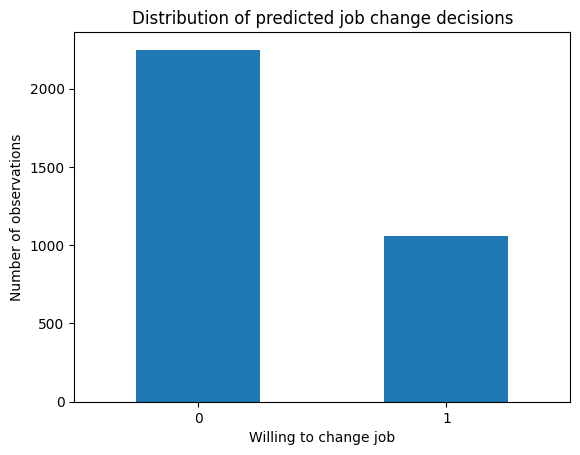

In [13]:
import matplotlib.pyplot as plt

submission[TARGET].value_counts().plot(kind="bar")

plt.title("Distribution of predicted job change decisions")
plt.xlabel("Willing to change job")
plt.ylabel("Number of observations")
plt.xticks(rotation=0)
plt.show()



In [11]:
from google.colab import files
files.download("outputs/predictions_job_change.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>